In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

from rapidgbm import RapidGBMTuner

import mplhep as hep
hep.style.use([hep.style.ATLAS])
import pickle

In [2]:
def concatenate_parquet_files(path):
    """
    Concatenate all parquet files in the given directory into a single DataFrame.

    Parameters:
    path (str): The directory containing the parquet files.

    Returns:
    pd.DataFrame: The concatenated DataFrame.
    """
    # List all files in the directory
    files = [f for f in os.listdir(path) if f.endswith('.parquet')]
    
    # Read and concatenate all parquet files
    dataframes = [pd.read_parquet(os.path.join(path, file)) for file in files]
    concatenated_df = pd.concat(dataframes, ignore_index=True)
    
    return concatenated_df

In [3]:
path_zee = '/groups/hep/kinch/data/preprocessed_data/files_for_dual_models/zee_deriv/single'
path_ttbar = '/groups/hep/kinch/data/preprocessed_data/files_for_dual_models/ttbar/single'

data_ttbar = concatenate_parquet_files(path_ttbar)
data_zeederiv = concatenate_parquet_files(path_zee)

print(f'TTbar data shape: {data_ttbar.shape}')
print(f'Zee deriv data shape: {data_zeederiv.shape}')

TTbar data shape: (2705661, 78)
Zee deriv data shape: (386770, 78)


In [4]:
print(len(data_ttbar.columns))
print(data_ttbar.shape[0])

78
2705661


In [5]:
print(data_zeederiv['el1_index'][data_zeederiv['el1_truthType']==2].value_counts())

el1_index
0     199600
1     119113
2       4246
3        557
4        173
5         63
6         40
7         24
8         14
9         11
10         6
12         4
23         2
11         1
21         1
14         1
22         1
26         1
16         1
13         1
Name: count, dtype: int64


In [6]:
param_list = ['el1_ptvarcone20', 'el1_topoetcone20', 'el1_topoetcone40', 'el1_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
               'el1_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000', 'el1_core57cellsEnergyCorrection',
               'el1_topoetcone20ptCorrection', 'el1_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt500',
               'el1_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500']

IsoElectron       =  2,

In [7]:
print(data_zeederiv['el1_truthType'].value_counts())
print(data_ttbar['el1_truthType'].value_counts())

el1_truthType
2     323860
17     22969
4      18181
0      16666
16      3534
15      1181
3        331
7         23
8         16
14         8
13         1
Name: count, dtype: int64
el1_truthType
17    1887296
2      284884
4      242912
16     110790
3      109386
0       44951
7       16578
6        4386
15       2135
8        1288
14       1044
19          7
13          4
Name: count, dtype: int64


In [8]:
num_iso = len(data_ttbar[data_ttbar['el1_truthType'] == 2]) + len(data_zeederiv[data_zeederiv['el1_truthType'] == 2])
print(f'Number of isolated electrons: {num_iso}')
print(f'Number of non-isolated electrons: {len(data_ttbar) + len(data_zeederiv) - num_iso}')

Number of isolated electrons: 608744
Number of non-isolated electrons: 2483687


In [9]:
signal1 = data_ttbar[data_ttbar['el1_truthType'] == 2]
background1 = data_ttbar[data_ttbar['el1_truthType'] != 2]

signal2 = data_zeederiv[data_zeederiv['el1_truthType'] == 2]
background2 = data_zeederiv[data_zeederiv['el1_truthType'] != 2]

signal = pd.concat([signal1, signal2]).reset_index(drop=True)
bck = pd.concat([background1, background2]).reset_index(drop=True)

print(f'initial signal size: {len(signal)}, initial background size: {len(bck)}')


background = bck.sample(n=len(signal), random_state=1)

bck = bck.drop(background.index)

# keep an eye on ratio of signal to background

print(f'final signal size: {len(signal)}, final background size: {len(background)}, final pure background size: {len(bck)}, ({len(bck)+len(background)})')


data = pd.concat([signal, background]).copy()

print('Number of duplicate rows in data:', (data[['eventNumber','el1_index']]).duplicated().sum())


print(((data['eventNumber'] % 4)).value_counts())
print('data:', len(signal))
# train = data[data['eventNumber'] % 4 != 0]
# test = data[data['eventNumber'] % 4 == 0]


train, test = train_test_split(data, test_size=0.25, random_state=1)

# train = data.sample(frac=0.75, random_state=13)
# test = data.drop(train.index)

print('train:', len(train), len(train)/(len(train) + len(test)))
print('test:', len(test), len(test)/(len(train) + len(test)))
print('ratio:', len(test)/len(train))

X_train = train[param_list]
y_train = train['el1_truthType'] == 2

initial signal size: 608744, initial background size: 2483687
final signal size: 608744, final background size: 608744, final pure background size: 1874943, (2483687)
Number of duplicate rows in data: 0
eventNumber
3    304843
1    304522
2    304260
0    303863
Name: count, dtype: int64
data: 608744
train: 913116 0.75
test: 304372 0.25
ratio: 0.3333333333333333


In [10]:
print(y_train.head(25))


775649     False
1188822    False
231502      True
2055613    False
776478     False
2420465    False
440729      True
1344405    False
327174      True
2110418    False
1727971    False
1527019    False
989955     False
486251      True
544705      True
808790     False
1062525    False
665993     False
608473      True
524949      True
140041      True
2003870    False
278061      True
544886      True
2018817    False
Name: el1_truthType, dtype: bool



 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: auc 
     .. Study direction: minimize log_loss

     . Trial number: 0 finished
     .. Optimization score (lower-better): log_loss: 0.11931065206207529
     .. Evaluation score (greater-better): auc: 0.9897845379825652
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): log_loss: 0.11814087080070348
     .. Evaluation score (greater-better): auc: 0.9899815208744752
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): log_loss: 0.1565339976480982
     .. Evaluation score (greater-better): auc: 0.9867430212888496
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): log_loss: 0.12123392999666587
 

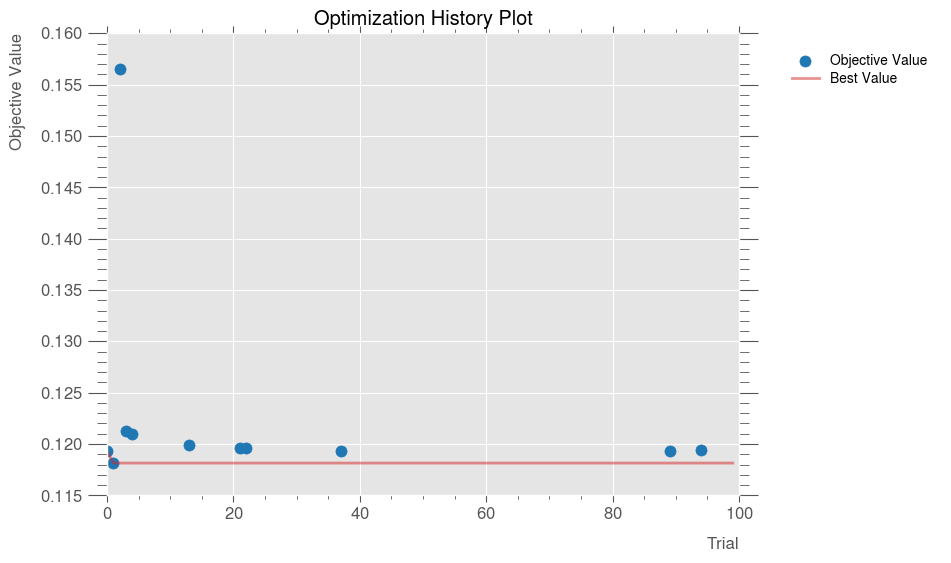

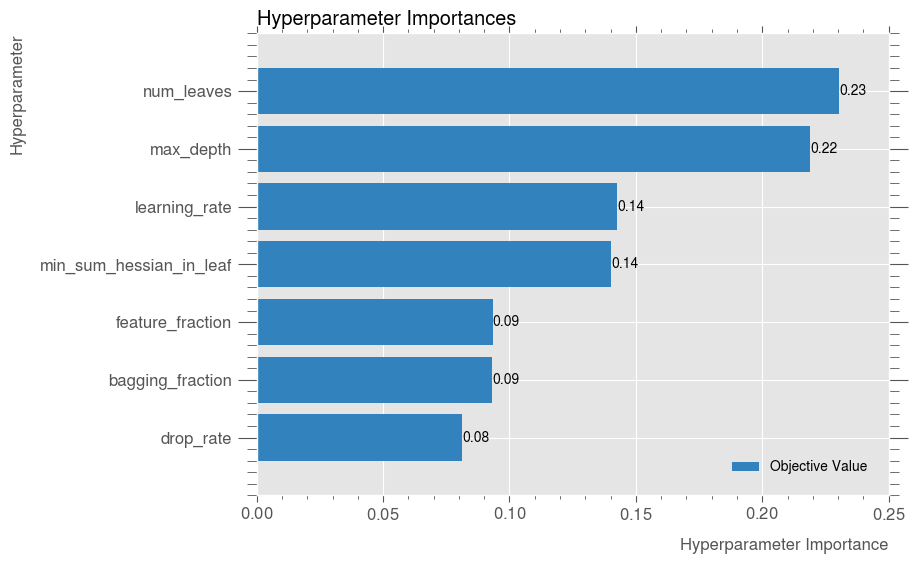

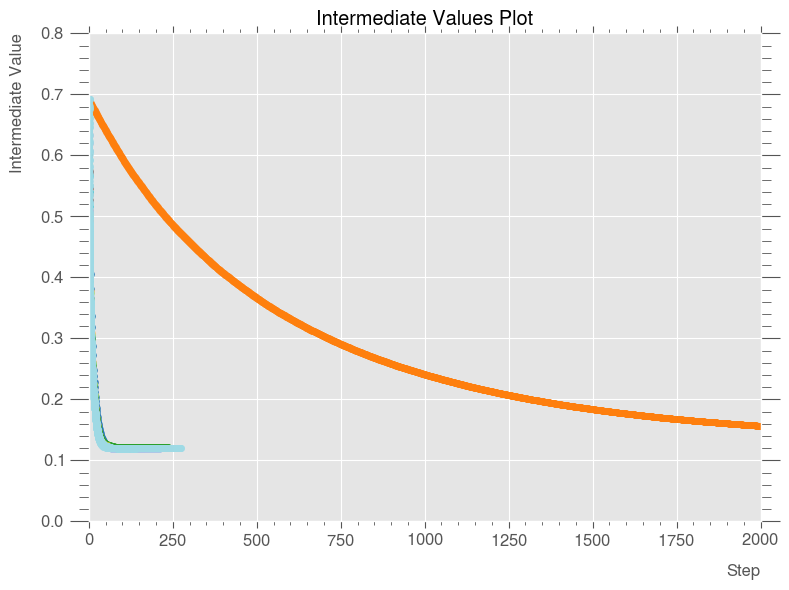

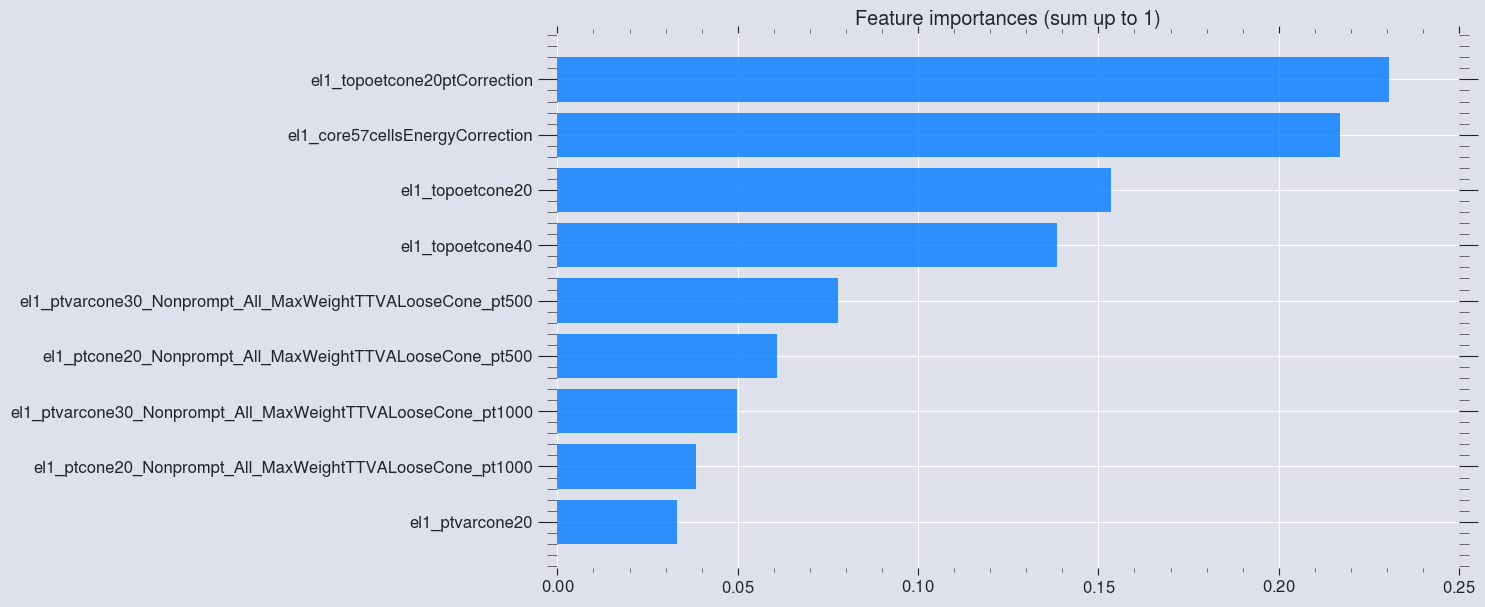


     . Optuna hyperparameters optimization finished
     .. Best trial number: 1    |     log_loss:          0.11814087080070348
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 2 min 44.658 sec

   - Fitting optimized model with the following params:
task                             : train
learning_rate                    : 0.08590567014128435
num_leaves                       : 169
feature_fraction                 : 0.9177173706728565
bagging_fraction                 : 0.6286323558605696
bagging_freq                     : 1
max_depth                        : 51
verbosity                        : -1
lambda_l1                        : 1
lambda_l2                        : 0.0
min_split_gain                   : 0.0
zero_as_missing                  : False
max_bin                          : 255
min_data_in_bin                  : 3
random_state                     : 42
device_type                      : cpu
num_classes          

In [11]:
tuner = RapidGBMTuner(metric='auc', trials=100, refit=True, verbosity=1, visualization=True, seed=414243)#, grid='h,learning_rate')

tuner.grid['max_depth'] = (0, 100)
tuner.grid['learning_rate'] = (0.00001, 0.1)
tuner.grid['drop_rate'] = (0.05,0.4)
# Fit tuner for each set of input_data
tuner.fit(X_train, y_train)

tuner.fit_optimized(X_train.to_numpy(), y_train.squeeze().to_numpy())

no


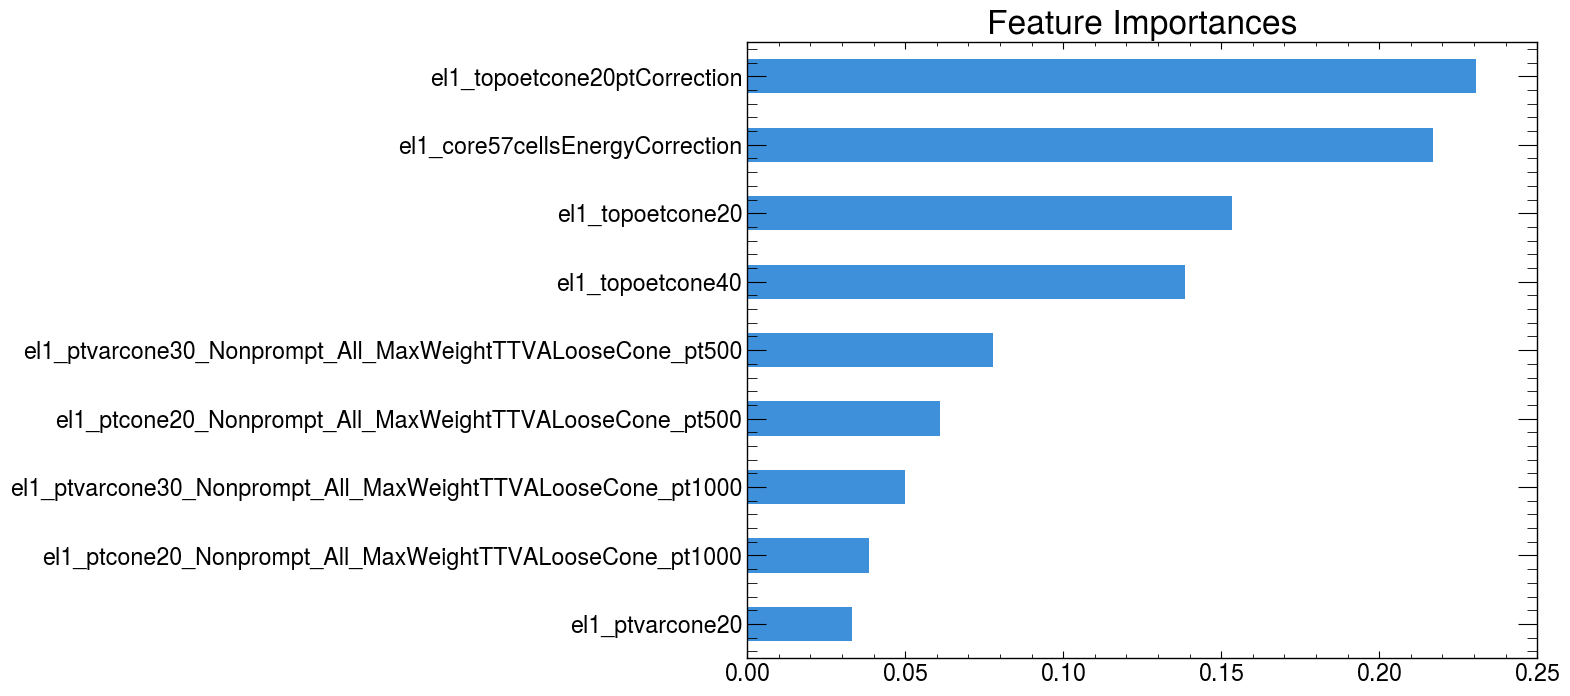

In [12]:
plt.rcdefaults()
hep.style.use([hep.style.ATLAS])

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Feature Importances')
tuner.feature_importances.sort_values().plot(ax=ax,kind='barh')
# ax.set_xticklabels(tuner.feature_importances.sort_values().index, rotation=45)
print('no')

AUC: 0.99, accuracy: 0.96


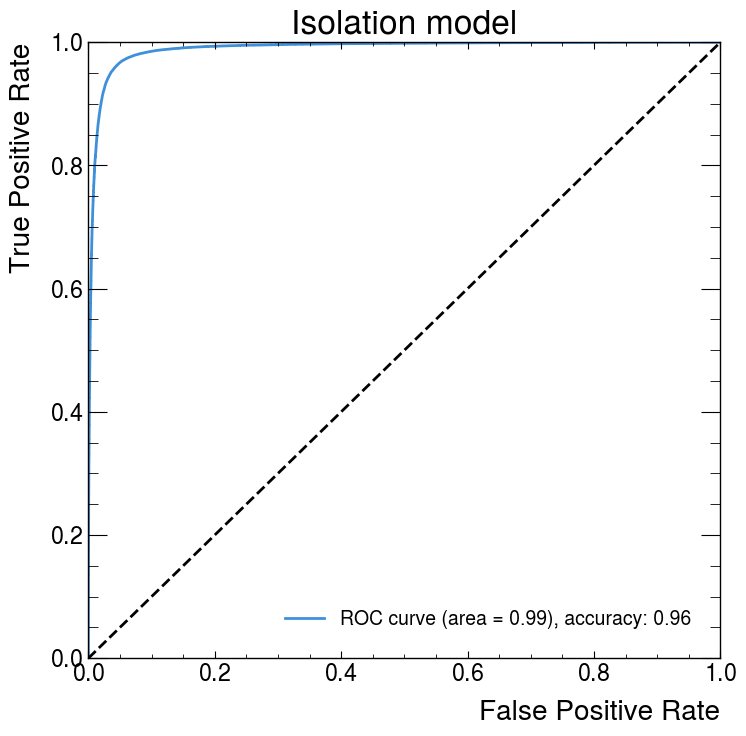

In [13]:
pred_score = tuner.predict_proba(test[param_list])
prediction = tuner.predict(test[param_list])
fpr, tpr, _ = roc_curve(test['el1_truthType'] == 2, pred_score)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}), accuracy: {np.mean(prediction == (test["el1_truthType"] == 2)):.2f}')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Isolation model')
ax.legend(loc='lower right')

print(f'AUC: {roc_auc:.2f}, accuracy: {np.mean(prediction == (test["el1_truthType"] == 2)):.2f}')

Text(0.5, 1.0, 'Isolation model')

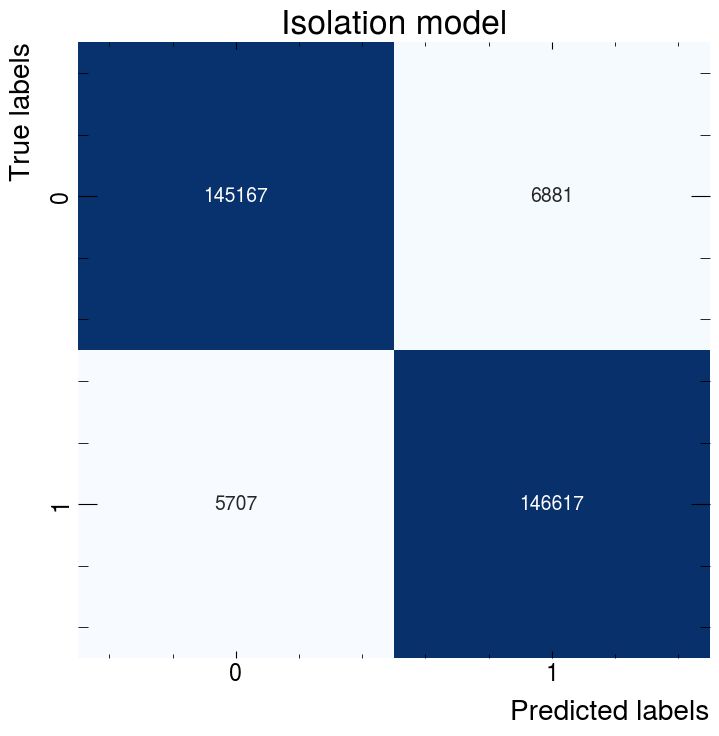

In [14]:
# confusion matrix:
conf_matrix = confusion_matrix(test['el1_truthType'] == 2, prediction)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Isolation model')

In [29]:
# save model
with open('iso_score_bdt_MC_zeederiv_ttbar_balanced_100ep_26Sept.pkl', 'wb') as file: #bdt_MC_HZg_mumu_1s02bkg_100ep_23Sept
    pickle.dump(tuner, file)
with open('iso_score_bdt_MC_zeederiv_ttbar_balanced_100ep_26Sept_variables.pkl', 'wb') as fp:
    pickle.dump(param_list, fp)

In [30]:
# with open('iso_score_bdt_MC_zeederiv_ttbar_balanced_100ep_26Sept.pkl', 'rb') as file:
#     tuner2 = pickle.load(file)

In [32]:
# prediction2 = tuner2.predict(test[param_list])
# print(f"models agree on prediction: {np.all(prediction == prediction2)}")

models agree on prediction: True
